# Autoencoders

Autoencoders (AEs) are neural network architectures designed to learn efficient, low-dimensional representations of high-dimensional data. They achieve this by compressing the input into a latent space and then reconstructing the original input from that compressed representation. This process forces the network to capture the most salient features of the data, enabling tasks such as dimensionality reduction, feature extraction, and data compression. The objective of an autoencoder is to minimize the reconstruction error between the input and the output, thereby ensuring that the latent representation retains as much useful information as possible.




In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

In [2]:
# setting the device
device= 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

True

In [3]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')

In [4]:
def plot_losses(train_hist, dev_hist):
    plt.plot(train_hist, label='Train loss')
    plt.plot(dev_hist, label='Dev loss')
    plt.legend()
    plt.show()

# Data Processing

The pixel values fall in the range of 0 to 255. As a preprocessing step, these pixel values are normalized to fall from 0 to 1. This is achieved by dividing each pixel value by 255. This normalization helps in faster and more stable convergence during training.

In [5]:
# calling the dataset
from tensorflow.keras.datasets import mnist

# access the training and test data
(Xtr_raw, Ytr_raw), (Xte_raw, Yte_raw)= mnist.load_data()

# data reformating - adding a channel dimension
Xtr_raw= np.expand_dims(Xtr_raw, 1)  # Grayscale images have 1 channel
Xte_raw= np.expand_dims(Xte_raw, 1)

# convert data to float32
Xtr_raw= Xtr_raw.astype(np.float32)
Xte_raw= Xte_raw.astype(np.float32)


IMG_MAXVAL= 255.0

# normalizing the training data
Xtr_raw /= IMG_MAXVAL

# normalizing the test data
Xte_raw /= IMG_MAXVAL


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# converting data to pytorch type
Xtr= torch.tensor(Xtr_raw, requires_grad=True).to(device)
Ytr= torch.tensor(Ytr_raw).to(device)
Xte= torch.tensor(Xte_raw, requires_grad=True).to(device)
Yte= torch.tensor(Yte_raw).to(device)

# transforming labels from numbers to one-hot vectors of length 10
Ytr= F.one_hot(Ytr.type(torch.int64), num_classes=10).type(torch.float32)
Yte= F.one_hot(Yte.type(torch.int64), num_classes=10).type(torch.float32)

# creating a dev dataset from training data
tr_size= int(0.8*Xtr.shape[0])

Xdev= Xtr[tr_size:]
Ydev= Ytr[tr_size:]

Xtr= Xtr[:tr_size]
Ytr= Ytr[:tr_size]

print(f'Shape of training: Xtr - {Xtr.shape}, Ytr - {Ytr.shape}')
print(f'Shape of dev data: Xdev - {Xdev.shape}, Ydev - {Ydev.shape}')
print(f'Shape of test data: Xte - {Xte.shape}, Yte - {Yte.shape}')

Shape of training: Xtr - torch.Size([48000, 1, 28, 28]), Ytr - torch.Size([48000, 10])
Shape of dev data: Xdev - torch.Size([12000, 1, 28, 28]), Ydev - torch.Size([12000, 10])
Shape of test data: Xte - torch.Size([10000, 1, 28, 28]), Yte - torch.Size([10000, 10])


# Autoencoders (AEs) architecture

An autoencoder consists of two primary components: an encoder and a decoder. The encoder maps input data to a lower-dimensional latent representation (often referred to as a code or bottleneck), thereby compressing the data while preserving its most salient features. The dimensionality of this bottleneck, or encoding dimension, is a hyperparameter typically set lower than that of the original input. The decoder then reconstructs the input data from the latent representation, aiming to minimize the reconstruction error. This reconstruction is inherently lossy, meaning that some information is lost in the compression process, as the model is optimized to approximate rather than exactly replicate the original input.

**NOTE:** I will use a CNN-based architecture here, but AEs are a more general concept.

In [7]:
class Encoder(nn.Module):
    """
    Define the Encoder module.
    """

    def __init__(self, embed_dim, image_size, input_chs, hidden_chs, output_chs,
                 kernels=3, paddings=1, max_pools=2, initp=True) -> None:
        super(Encoder, self).__init__()
        # convolutional layers
        self.conv_in= nn.Conv2d(input_chs, hidden_chs[0], kernels, padding=paddings)
        self.m_pool1= nn.MaxPool2d(max_pools)
        self.activ1= nn.ReLU(inplace=True)

        self.conv_hn= nn.Conv2d(hidden_chs[0], hidden_chs[1], kernels, padding=paddings)
        self.m_pool2= nn.MaxPool2d(max_pools)
        self.activ2= nn.ReLU(inplace=True)

        self.conv_out= nn.Conv2d(hidden_chs[1], output_chs, kernels, padding=paddings)
        self.m_pool3= nn.MaxPool2d(max_pools)
        self.activ3= nn.ReLU(inplace=True)

        self.flatten= nn.Flatten()
        # compute the flattened size after convolutions
        self.flat_size= ((image_size//(max_pools**3))**2) * output_chs
        # fully connected layer to create embeddings
        self.out_layer= nn.Linear(self.flat_size, embed_dim)

        if initp:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                    if m.bias is not None: nn.init.zeros_(m.bias)
                elif isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None: nn.init.zeros_(m.bias)


    def forward(self, x):
        z= self.activ1(self.m_pool1(self.conv_in(x)))
        z= self.activ2(self.m_pool2(self.conv_hn(z)))
        z= self.activ3(self.m_pool3(self.conv_out(z)))
        z= self.out_layer(self.flatten(z))

        return z  # outputs an encoded latent space


Upsampling and convolution transpose:

https://www.youtube.com/watch?v=ByjaPdWXKJ4 17:00min


In [8]:
class Decoder(nn.Module):
    """
    Define the Decoder module.
    """

    def __init__(self, embed_dim, output_linear, input_chs, hidden_chs, output_chs,
                 kernels=3, paddings=1, strides=2, initp=True) -> None:
        super(Decoder, self).__init__()
        # fully connected layer to reshape flatten tensor to 2D tensor
        self.in_layer= nn.Linear(embed_dim, output_linear)
        unflat_size= int((output_linear // input_chs)**0.5)
        unflat_dims= torch.Size([input_chs, unflat_size, unflat_size])
        self.make2d= nn.Unflatten(1, unflat_dims)

        # convT layers -- in_channels, out_channels, kernel_size, stride, padding, output_padding
        self.convT_in= nn.ConvTranspose2d(input_chs, input_chs, kernels, strides, paddings, paddings)
        self.activ1= nn.ReLU(inplace=True)
        self.convT_hn= nn.ConvTranspose2d(input_chs, hidden_chs[0], kernels, strides, paddings-1, paddings)
        self.activ2= nn.ReLU(inplace=True)
        self.convT_out= nn.ConvTranspose2d(hidden_chs[0], hidden_chs[1], kernels, strides, paddings, paddings)
        self.activ3= nn.ReLU(inplace=True)
        # final convolutional layer to generate output image
        self.conv_out= nn.Conv2d(hidden_chs[1], output_chs, kernels, padding=paddings)

        if initp:
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                    if m.bias is not None: nn.init.zeros_(m.bias)
                elif isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None: nn.init.zeros_(m.bias)


    def forward(self, z):
        x= self.make2d(self.in_layer(z))
        x= self.activ1(self.convT_in(x))
        x= self.activ2(self.convT_hn(x))
        x= self.activ3(self.convT_out(x))
        x= self.conv_out(x)

        return F.sigmoid(x)  # outputs a decoded image from a latent space


In [ ]:
# https://pyimagesearch.com/2023/07/17/implementing-a-convolutional-autoencoder-with-pytorch/

In [9]:
class Autoencoder(nn.Module):
    """
    Define the Autoencoder (Encoder-Decoder) model.
    """

    def __init__(self, embed_dim, image_size, input_chs, hidden_chs, output_chs,
                 kernels=3, paddings=1, max_pools=2, initp=True) -> None:
        super(Autoencoder, self).__init__()
        self.embed_dim= embed_dim
        # define the Encoder-Decoder architecture
        self.encoder= Encoder(
            embed_dim, image_size, input_chs, hidden_chs, output_chs, kernels,
            paddings, max_pools, initp
        )
        dec_input_chs= output_chs
        dec_hidden_chs= hidden_chs[::-1]
        dec_output_chs= input_chs
        dec_strides= max_pools

        self.decoder= Decoder(
            embed_dim, self.encoder.flat_size, dec_input_chs, dec_hidden_chs, dec_output_chs,
            kernels, paddings, dec_strides, initp
        )


    def encode(self, x):
        encoded= self.encoder(x)
        # outputs an encoded latent space
        return encoded


    def decode(self, z):
        decoded= self.decoder(z)
        # outputs a decoded image from a latent space
        return decoded


    def forward(self, x):
        encoded= self.encode(x)
        decoded= self.decode(encoded)

        return encoded, decoded


In [ ]:
# --- encoder defs ---
embed_dim= 64
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128

enc_model= Encoder(embed_dim, image_size, input_chs, hidden_chs, output_chs).to(device)

# Encode a sample image and generate a latent vector
y_enc= enc_model(Xtr[:1])
y_enc.shape

torch.Size([1, 64])

In [ ]:
# --- decoder defs ---
embed_dim= y_enc.shape[1]
output_linear= enc_model.flat_size
input_chs= 128
hidden_chs= [64,32]
output_chs= Xtr.shape[1]

dec_model= Decoder(embed_dim, output_linear, input_chs, hidden_chs, output_chs).to(device)

# Decode a latent vector
y_dec= dec_model(y_enc)
y_dec.shape

torch.Size([1, 1, 28, 28])

**NOTE -- Unsupervised learning and Autoencoders:**

https://www.youtube.com/watch?v=ekyBklxwQMU 32:05min

**Unsupervised feature learning:** After training the Autoencoder, we can throw away the decoder, refresh the FC network of at the end of the encoder and fine tune it as as classifier (updating the code to something like the backbone-head archtecture we implemented for SSL).

Therefore, Autoencoders can reconstruct data and can learn features to initialize a supervised model. We can also use them to generate data by learning probability distributions about our data (latent spaces) and how probability distributions can fit together to generate datasets.

In [ ]:
# --- AE defs ---
embed_dim= 64
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128

ae_model= Autoencoder(embed_dim, image_size, input_chs, hidden_chs, output_chs).to(device)

# Encode a sample image and decode its latent vector
y_en, y_dec= ae_model(Xtr[:1])
y_en.shape, y_dec.shape

(torch.Size([1, 64]), torch.Size([1, 1, 28, 28]))

In [ ]:
count_parameters(ae_model)

ae_model

Number of parameters: 481473


Autoencoder(
  (encoder): Encoder(
    (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ1): ReLU(inplace=True)
    (conv_hn): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ2): ReLU(inplace=True)
    (conv_out): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ3): ReLU(inplace=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (out_layer): Linear(in_features=1152, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (in_layer): Linear(in_features=64, out_features=1152, bias=True)
    (make2d): Unflatten(dim=1, unflattened_size=torch.Size([128, 3, 3]))
    (convT_in): ConvTranspose2d(128, 128, kernel_size=(3, 3), stri

# Contractive Autoencoders

It is a type of AE where the regularization term is based on the contractive property. The contractive property refers to the fact that Contractive AEs work on the basis that similar inputs should have similar encodings and a similar latent space representation. It means that the latent space should not vary by a huge amount for minor variations in the input. Therefore, a Contractive AE is designed to learn a compressed representation of the input data that is insensitive to small perturbations. As a result, the encoding layer "contracts" the input data into a compressed representation that captures the essential features of the data.

https://medium.com/@ompramod9921/autoencoders-explained-a223a5268618

# Contractive Loss

In the context of machine learning, perturbations refer to small changes or variations made to the input data in order to study the behaviour of a model or to improve its robustness by testing its ability to generalize to slightly different inputs. These perturbations can be intentional or random, and can be applied to different types of data, such as images, text, and numerical data. For example, in the context of image classification, perturbations can be applied to an image by adding small amounts of noise or changing the brightness, contrast, or orientation of the image. By doing so, we can study how the classification model responds to different types of input variations and assess its robustness to different types of noise or image transformations.

This is achieved by adding a penalty term to the loss function that measures the sensitivity of the encoding layer to small changes in the input data. The total loss function of a contractive autoencoder is a combination of two terms: the reconstruction loss ($L_{recon}$) and a regularization term ($\beta * ||J_f(x)||^2_F$). The reconstruction loss is the same as in a standard autoencoder and measures the difference between the input and the reconstructed output. The regularization term, on the other hand, penalizes the encoding layer for being too sensitive to small changes in the input data.

The squared Frobenius norm of the Jacobian matrix measures the sensitivity of the encoding layer to small changes in the input data. A higher norm value implies that the encoding layer is more sensitive to input perturbations, and a lower norm value implies that the encoding layer is more robust to input variations. Therefore, minimizing the squared Frobenius norm encourages the encoding layer to learn a more robust representation of the input data.

In [10]:
class ContractiveLoss:
    """
    Define the Contractive Autoencoder Loss function.
    """

    def __init__(self, beta_penalty=1.0, reduction='mean') -> None:
        super().__init__()
        assert reduction in ('sum', 'mean'), "reduction must be 'sum' or 'mean'"
        self.beta_penalty= beta_penalty
        self.reduction= reduction


    def __call__(self, encoder, y_pred, y_true):
        """
        encoder: encoder module that maps input x to latent z
        y_true: input tensor (the "target" for reconstruction is usually the input x itself)
        y_pred: reconstructed output from decoder.
        """
        # ensure input requires gradients for Jacobian calculation
        y_true.requires_grad_(True)
        z= encoder(y_true)

        # calculate the reconstruction loss
        reconstruction_loss= F.mse_loss(y_pred, y_true, reduction=self.reduction)

        # calculate contractive penalty (squared Frobenius norm of Jacobian)
        contractive_penalty= 0.0
        batch_size= y_true.size(0)

        for i in range(batch_size):
            grad_z= torch.autograd.grad(z[i].sum(), y_true, retain_graph=True, create_graph=True)[0][i]
            contractive_penalty += torch.sum(grad_z ** 2)

        if self.reduction== 'mean':
            contractive_penalty /= batch_size  # normalize
        # stop further gradient‐tracking through y_true
        y_true= y_true.detach()

        loss= reconstruction_loss + self.beta_penalty * contractive_penalty

        return loss   # return the total loss


In [ ]:
# https://stackoverflow.com/questions/58249160/how-to-implement-contractive-autoencoder-in-pytorch

# Training the Contractive AE

In practice, L2 loss is not used anymore because the L2 is not quite the right loss for actually learning features.

https://www.youtube.com/watch?v=ekyBklxwQMU 45:00min

In [11]:
def c_autoencoder_training(model, learning_rate=1e-3, epochs=500, eval_interval=5, batches:bool=True,
                           batch_size=64, shuffle:bool=True, early_stop:bool=True, patience=5, cutoff=1e-9):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= math.floor(Xtr.shape[0]/ batch_size)
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # loss function
    loss_tr_fn= ContractiveLoss()
    loss_ev_fn= nn.MSELoss()

    # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
    scheduler= ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.1, min_lr=1e-6)

    # for early stoping
    patience_count= 0
    previous_loss= 1e10

    # tracking statistics
    train_hist= []
    dev_hist= []
    schedule_hist= []

    # training data indexes
    ix= torch.arange(0, Xtr.shape[0])

    # --- training loop ---
    for epoch in tqdm(range(epochs)):

        batch_loss= []
        batch_schedule= []

        # iterating over all batches
        if shuffle:
            ix= torch.randperm(Xtr.shape[0])[:Xtr.shape[0]]

        for i in range(epoch_size):
            # --- minibatch construction ---
            Xmb= Xtr[ix[(i * batch_size) : ((i+1) * batch_size)]]

            # --- forward pass and get loss ---
            model.train(True)
            _, y_enc_dec= model(Xmb)
            loss_tr= loss_tr_fn(model.encoder, y_enc_dec, Xmb)
            batch_loss.append(loss_tr.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss_tr.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                _, y_enc_dec= model(Xdev)
                loss_dev= loss_ev_fn(y_enc_dec, Xdev)

        dev_hist.append(loss_dev.item())
        schedule_hist.append(scheduler.get_last_lr())
        scheduler.step(train_hist[-1]) # step learning rate scheduler


        # --- early stopping -- calculating loss change ---
        loss_change= np.abs(previous_loss - train_hist[-1])
        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and loss_change< cutoff):
            patience_count += 1

            if patience_count> patience:
                print('\nEarly stopping at epoch {}'.format(epoch))
                model.train(False)
                break
        else:
            patience_count= 0
        # setting current train loss as previous loss
        previous_loss= train_hist[-1]


    return train_hist, dev_hist, schedule_hist


In [12]:
def eval_autoencoder(model, test_data, loss_fn=nn.MSELoss()):

    model.train(False)
    with torch.no_grad():
        _, y_enc_dec= model(test_data)
        loss_test= loss_fn(y_enc_dec, test_data)

    return loss_test.item()


In [13]:
# --- AE defs ---
embed_dim= 64
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128

ae_model= Autoencoder(embed_dim, image_size, input_chs, hidden_chs, output_chs).to(device)

train_hist, dev_hist, schedule_hist= c_autoencoder_training(ae_model, learning_rate=1e-3, epochs=30,
                                                            batch_size=256, eval_interval=2, cutoff=1e-4)

100%|██████████| 30/30 [1:53:25<00:00, 226.85s/it]


In [14]:
eval_autoencoder(ae_model, Xte)

0.008705214597284794

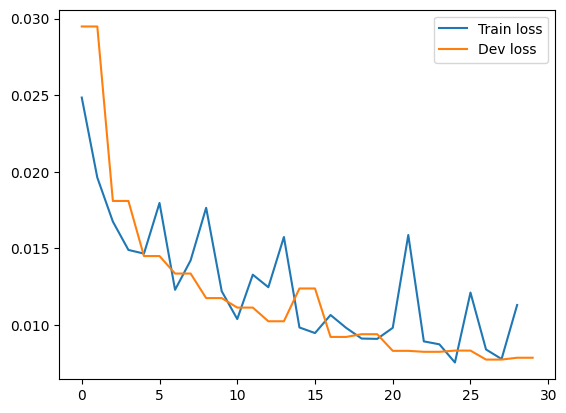

In [28]:
plot_losses(train_hist[1:], dev_hist)

# Inferring the Contractive AE model

In [16]:
def contractive_sample(model, data, img_index):
    # Select an image from the test set
    test_img= data[img_index:img_index+1]

    model.eval()
    latent_vector, generated_img= model(test_img)

    # Plot the original image and the generated image
    plt.subplot(1, 2, 1)
    plt.imshow(test_img[0][0].cpu().detach().numpy(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(generated_img[0][0].cpu().detach().numpy(), cmap='gray')
    plt.title('Generated Image')
    plt.axis('off')
    plt.show()

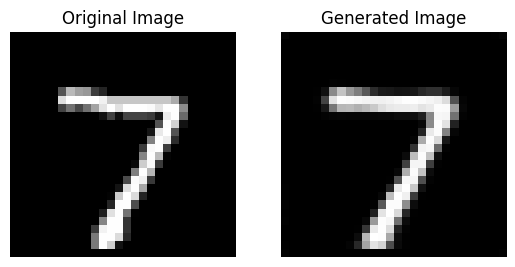

In [17]:
contractive_sample(model=ae_model, data=Xte, img_index=0)

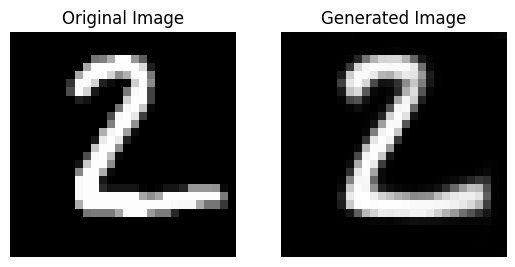

In [29]:
contractive_sample(model=ae_model, data=Xte, img_index=1)

# Denoising Autoencoders

In traditional Autoencoders, the goal is to learn a compressed representation that preserves the essential information in the data. However, if the input data is noisy or corrupted, the autoencoder may learn to encode and decode the noise as well, resulting in a poor compressed representation. Denoising autoencoders address this problem by learning to denoise the input data during training.

One approach to encourage an autoencoder to learn a useful representation of data is to keep the code layer small. This forces the model to learn an intelligent representation of the data rather than simply copying the input to the output. Another approach is to add random noise to the input data and train the autoencoder to recover the original, noise-free data. This way the autoencoder can't simply copy the input to its output because the input also contains random noise. This technique is called a denoising autoencoder and helps ensure that the model is subtracting the noise and learning the underlying meaningful features of the data.

The amount and type of noise added can vary depending on the problem being solved. For example, in image denoising tasks, random noise can be added to the pixels of an image to create a noisy version of the image. The noise can be added in various ways, such as Gaussian noise, salt-and-pepper noise, or random pixel dropout. Similarly, in speech denoising tasks, random noise can be added to the audio signal to create a noisy version of the speech.

**Data augmentation by adding Gaussian noise**

In [ ]:
class NoiseAugment:
    """
    A data augmentation module based on adding Gaussian noise to images.
    """

    def __init__(self, sigma=0.1, norm=False) -> None:
        self.sigma= sigma
        self.norm = norm


    def __call__(self, x):
        # Generate Gaussian noise
        noise= torch.randn(size=x.shape).to(device)
        if self.norm:
            noise -= noise.amin(dim=(1,2,3), keepdim=True)
            noise /= noise.amax(dim=(1,2,3), keepdim=True)

        # Clip the images to be between 0 and 1
        return torch.clip((x + (self.sigma * noise)), min=0.0, max=1.0)


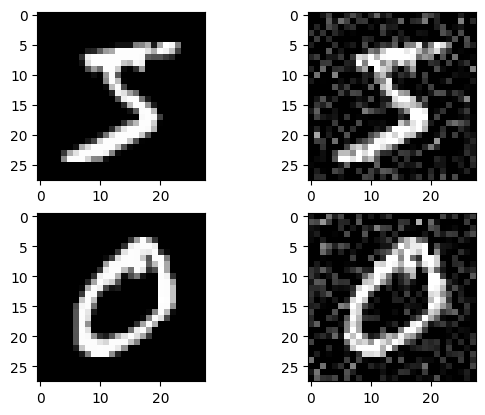

In [ ]:
# generating test augmentation
a= NoiseAugment(sigma=0.2, norm=False)
aug= a(Xtr[0:2])

f, axarr= plt.subplots(2, 2)

# original image - positive pair
axarr[0, 0].imshow(Xtr[0][0].cpu().detach().numpy(), cmap='gray')
axarr[0, 1].imshow(aug[0][0].detach().cpu().numpy(), cmap='gray')

# original image - positive pair
axarr[1, 0].imshow(Xtr[1][0].cpu().detach().numpy(), cmap='gray')
axarr[1, 1].imshow(aug[1][0].detach().cpu().numpy(), cmap='gray')
plt.show()

The noisy image X' can be obtained by adding the noise matrix N to the original image X, i.e., X' = X + N. The amount of noise added can be controlled by adjusting the value of sigma. For example, if sigma=0.1, then the noise added will be small and the resulting image will still be relatively clear. On the other hand, if sigma=1.0, then the noise added will be much larger and the resulting image will be much noisier.

After adding the noise, we use these corrupted images as input to the denoising autoencoder and the network is then trained to reconstruct the original, clean data from the noisy input by minimizing the difference between the reconstructed output and the clean input.

# Training the Denoising AE

In [ ]:
def d_autoencoder_training(model, learning_rate=1e-3, epochs=500, eval_interval=5, noise_level=0.1,
                           batches:bool=True, batch_size=64, shuffle:bool=True,
                           early_stop:bool=True, patience=5, cutoff=1e-9):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= math.floor(Xtr.shape[0]/ batch_size)
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # loss function
    loss_fn= nn.BCELoss()

    # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
    scheduler= ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.1, min_lr=1e-6)

    # data augmentation function
    augment_fn= NoiseAugment(sigma=noise_level)

    # for early stoping
    patience_count= 0
    previous_loss= 1e10

    # tracking statistics
    train_hist= []
    dev_hist= []
    schedule_hist= []

    # training data indexes
    ix= torch.arange(0, Xtr.shape[0])

    # --- training loop ---
    for epoch in tqdm(range(epochs)):

        batch_loss= []
        batch_schedule= []

        # iterating over all batches
        if shuffle:
            ix= torch.randperm(Xtr.shape[0])[:Xtr.shape[0]]

        for i in range(epoch_size):
            # --- minibatch construction ---
            Xmb= Xtr[ix[(i * batch_size) : ((i+1) * batch_size)]]
            # creating noise batches
            Xmb_noise= augment_fn(Xmb)

            # --- forward pass and get loss ---
            model.train(True)
            _, y_enc_dec= model(Xmb_noise)
            loss_tr= loss_fn(y_enc_dec, Xmb)
            batch_loss.append(loss_tr.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss_tr.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                Xdev_noise= augment_fn(Xdev)
                _, y_enc_dec= model(Xdev_noise)
                loss_dev= loss_fn(y_enc_dec, Xdev)

        dev_hist.append(loss_dev.item())
        schedule_hist.append(scheduler.get_last_lr())
        scheduler.step(train_hist[-1]) # step learning rate scheduler


        # --- early stopping -- calculating loss change ---
        loss_change= np.abs(previous_loss - train_hist[-1])
        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and loss_change< cutoff):
            patience_count += 1

            if patience_count> patience:
                print('\nEarly stopping at epoch {}'.format(epoch))
                model.train(False)
                break
        else:
            patience_count= 0
        # setting current train loss as previous loss
        previous_loss= train_hist[-1]


    return train_hist, dev_hist, schedule_hist


In [ ]:
# --- AE defs ---
embed_dim= 64
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128

dae_model= Autoencoder(embed_dim, image_size, input_chs, hidden_chs, output_chs).to(device)

dtrain_hist, ddev_hist, dschedule_hist= d_autoencoder_training(dae_model, learning_rate=1e-3, epochs=30,
                                                               noise_level=0.25, batch_size=256,
                                                               eval_interval=2, cutoff=1e-4)


100%|██████████| 30/30 [20:36<00:00, 41.23s/it]


0.08230194449424744


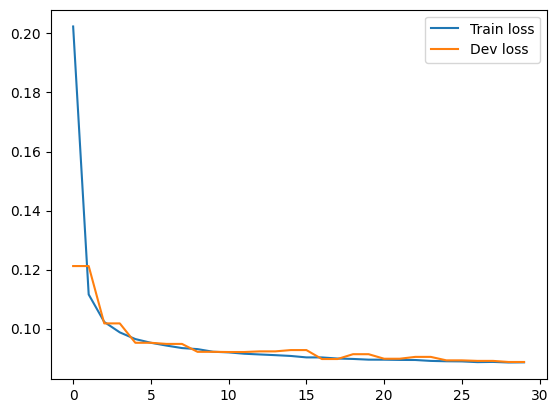

In [ ]:
# ploting
print(eval_autoencoder(dae_model, Xte, nn.BCELoss()))

plot_losses(dtrain_hist, ddev_hist)

# Inferring the Denoising AE model

In [ ]:
def denoise_sample(model, data, img_index, sigma=0.25):
    # Select an image from the test set
    test_img= data[img_index:img_index+1]

    a= NoiseAugment(sigma)
    noise_img= a(test_img)

    model.eval()
    latent_vector, generated_img= model(test_img)

    # Plot the original image and the generated image
    plt.subplot(1, 3, 1)
    plt.imshow(test_img[0][0].cpu().detach().numpy(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(noise_img[0][0].cpu().detach().numpy(), cmap='gray')
    plt.title('Noise Image')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(generated_img[0][0].cpu().detach().numpy(), cmap='gray')
    plt.title('Generated Image')
    plt.axis('off')
    plt.show()

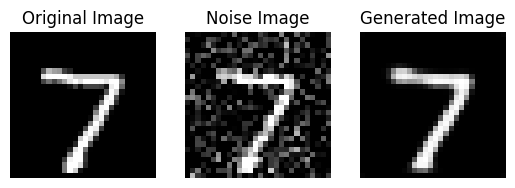

In [ ]:
denoise_sample(model=dae_model, data=Xte, img_index=0, sigma=0.25)

In [ ]:
# https://medium.com/@ompramod9921/autoencoders-explained-9196c38af6f6
# https://pyimagesearch.com/2023/07/17/implementing-a-convolutional-autoencoder-with-pytorch/

# Variational Autoencoders (VAEs)

Variational Autoencoders (VAEs) extend the traditional autoencoder framework by introducing a probabilistic approach to the latent representation. Instead of mapping an input deterministically to a single point, the encoder outputs a distribution—typically a multivariate Gaussian—over the latent space. During decoding, samples drawn from this distribution are used to reconstruct the input, enabling the generation of new data instances.

As a class of generative models, VAEs learn an approximation of the underlying probability distribution of the input data, which allows them to synthesize novel samples resembling the training data. The VAE loss function comprises two components: a reconstruction loss that quantifies the discrepancy between the original input and its reconstruction, and a regularization term that encourages the learned latent distribution to be close to a chosen prior (usually a standard Gaussian). This regularization is typically enforced using the Kullback-Leibler divergence.

The conditional distribution $p_{\theta}(x|z)$ is modeled by the decoder network. For continuous data, it is typically assumed to be a multivariate Gaussian, ${\mathcal {N}(x; \mu_{\theta}(z), \sigma ^{2}_{\theta}I)}$, where the parameters $\mu_{\theta}(z)$ and $\sigma_{\theta}$ are learned by the decoder. For binary data, a Bernoulli distribution is often employed.

The key innovation of VAEs lies in their ability to learn a structured and continuous latent space that not only compresses the data but also enables the generation of high-quality, novel data samples.

https://www.youtube.com/watch?v=ekyBklxwQMU 48:00min

In [18]:
class VAE(Autoencoder):
    """
    Define the Variational Autoencoder model.
    """

    def __init__(self, embed_dim, image_size, input_chs, hidden_chs, output_chs,
                 kernels=3, paddings=1, max_pools=2, initp=True) -> None:
        super(VAE, self).__init__(embed_dim, image_size, input_chs, hidden_chs, output_chs,
                                  kernels, paddings, max_pools)
        # define mu and log(variance) layers for reparameterization
        self.mu     = nn.Linear(embed_dim, embed_dim)
        self.log_var= nn.Linear(embed_dim, embed_dim)


    def reparameterize(self, mu, log_var):
        # compute the standard deviation from the log(variance)
        std= torch.exp(0.5 * log_var)
        # generate random noise using the same shape as std
        gen_noise= torch.randn_like(std)

        return mu + std * gen_noise # return the reparameterized sample


    def forward(self, x):
        encoded= self.encode(x)
        mu= self.mu(encoded)                # compute the mean and log(variance) vectors
        log_var= self.log_var(encoded)
        z= self.reparameterize(mu, log_var) # reparameterize the latent variable
        decoded= self.decode(z)

        return encoded, decoded, mu, log_var


The reason for representing the logarithm of the variance, not the variance directly, is because we don't want the variance to ever become negative. Instead, we ensure positive values for the standard deviation (square root of the variance) by exponentiating it (std = torch.exp(0.5 * log_var)). Here, exponentiating by 0.5 is equivalent to the square root operation.

The decoder then literally draws a random number using the expression randn_like(). As the random number is simply a factor in mu + eps * std, the gradient computation is not affected, and the model can learn appropriate parameters that minimize the error.

In [ ]:
# --- VAE defs ---
embed_dim= 64
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128

vae_model= VAE(embed_dim, image_size, input_chs, hidden_chs, output_chs).to(device)

count_parameters(vae_model)

vae_model

Number of parameters: 489793


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ1): ReLU(inplace=True)
    (conv_hn): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ2): ReLU(inplace=True)
    (conv_out): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ3): ReLU(inplace=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (out_layer): Linear(in_features=1152, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (in_layer): Linear(in_features=64, out_features=1152, bias=True)
    (make2d): Unflatten(dim=1, unflattened_size=torch.Size([128, 3, 3]))
    (convT_in): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2

In [ ]:
# Encode a sample image and decode its latent vector
y_en, y_dec, _, _= vae_model(Xtr[:1])
y_en.shape, y_dec.shape

(torch.Size([1, 64]), torch.Size([1, 1, 28, 28]))

The Evidence Lower Bound (ELBO) is the cornerstone objective function for training Variational Autoencoders (VAEs). Since the marginal likelihood $p_{\theta}(x)$ of the observed data is generally intractable, VAEs optimize the ELBO — a tractable lower bound on the log-likelihood. Mathematically, the ELBO is expressed as

$$
\mathcal{L}(\theta,\phi;x) = \mathbb{E}_{q_{\phi}(z\mid x)}\left[\log p_{\theta}(x\mid z)\right] - D_{\mathrm{KL}}\left(q_{\phi}(z\mid x) \,\Vert\, p(z)\right)
$$

where $q_{\phi}(z \mid x)$ is the approximate posterior, $p(z)$ is the prior (typically a standard Gaussian), and $p_{\theta}(x \mid z)$ is the likelihood modeled by the decoder. The first term, $\mathbb{E}{q{\phi}(z \mid x)}[\log p_{\theta}(x \mid z)]$, is the expected log-likelihood (or reconstruction term), measures how well the decoder reconstructs the input $x$ from latent samples $z$. The second term, $D_{\mathrm{KL}}(q_{\phi}(z \mid x) , | , p(z))$, is the Kullback-Leibler divergence, acts as a regularizer that forces the approximate posterior to remain close to the prior. Maximizing the ELBO simultaneously encourages accurate reconstruction and a well-structured latent space, thus facilitating both data compression and generation.

# Reconstruction + KL Divergence Loss

If we train the VAE with the mean-square error loss from above, we will get the exact same results as with a standard AE. In fact, training will ignore the eps*std term by converging to a zero standard deviation. If we want the VAE to result in a true Gaussian distribution, we need an additional loss term. One way to compare two distributions P(x) and Q(x) is the Kullback-Leibler divergence. Distribution Q is a zero-mean, variance-one Gaussian distribution — the distribution that we want — the other is the one that we are actually learning.

In [19]:
class KLDivergenceLoss:
    """
    Reconstruction + KL Divergence losses summed over all elements and batch.
    See Appendix B from VAE paper:
    Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    https://arxiv.org/abs/1312.6114
    """

    def __init__(self, beta_penalty=1.0, reduction='sum') -> None:
        super().__init__()
        assert reduction in ('sum', 'mean'), "reduction must be 'sum' or 'mean'"
        self.beta_penalty= beta_penalty
        self.reduction= reduction


    def __call__(self, y_pred, y_true, mu, log_var):
        # BCE loss between the reconstructed output and the input data
        BCE= F.binary_cross_entropy(y_pred, y_true, reduction=self.reduction)
        # KLD between the learned latent variable distribution and a std Gaussian distribution
        KLD= -0.5 * torch.sum(1.0 + log_var - mu.pow(2) - log_var.exp(), dim=1)

        # reduce KL over the batch
        if self.reduction== 'mean':
            KLD= torch.mean(KLD)  # scalar: average over batch
        else:
            KLD= torch.sum(KLD)   # scalar: sum over batch

        return BCE + self.beta_penalty * KLD  # combine the two losses by adding them together


The **$\beta$ penalty** is a weight factor to decide the relative weightage between KL and reconstruction loss (BCE). Setting it very high will lead to bad reconstructions, and setting it very low(~0) will make the VAE as a pure Autoencoder so that it will have the same issues as an Autoencoder. So, it is a weight parameter that we tune.

**Disentangled VAEs:** with $\beta$ typically defined either greater than or equal to 1. When $\beta$ is equal to 1, we just have a classic VAE. However, when $\beta$ is greater than one, the effects of KL divergence take a greater effect. When the penalty for KL divergence is increased, the $\beta$-VAE is more disincentivized to create distributions that deviate from a mean of zero and a standard deviation of 1. Thus, $\beta$-VAEs will make as few distributions as possible to encode the information, making $\beta$-VAEs much more likely to encode high-level information within the latent space. When $\beta$-VAEs are applied to images of faces, for instance, they're likely to encode very human interpretable information in their dimensions, such as rotation, smiling, light direction, ethnicity, etc. The reason is that even if a $\beta$-VAE can encode more subtle information across multiple spots in the latent space, it's heavily incentivized not to and to instead encode information via high-level features that are broadly applicable.

In [ ]:
# https://medium.com/intuitively-and-exhaustively-explained/disentangled-variational-autoencoders-intuitively-and-exhaustively-explained-273b0dc92e8a

# Training the VAE

In [20]:
def vae_training(model, learning_rate=1e-3, epochs=500, eval_interval=5, batches:bool=True,
                 batch_size=64, shuffle:bool=True, early_stop:bool=True, patience=5, cutoff=1e-9):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= math.floor(Xtr.shape[0]/ batch_size)
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # loss function
    loss_fn= KLDivergenceLoss()

    # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
    scheduler= ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.1, min_lr=1e-6)

    # for early stoping
    patience_count= 0
    previous_loss= 1e10

    # tracking statistics
    train_hist= []
    dev_hist= []
    schedule_hist= []

    # training data indexes
    ix= torch.arange(0, Xtr.shape[0])

    # --- training loop ---
    for epoch in tqdm(range(epochs)):

        batch_loss= []
        batch_schedule= []

        # iterating over all batches
        if shuffle:
            ix= torch.randperm(Xtr.shape[0])[:Xtr.shape[0]]

        for i in range(epoch_size):
            # --- minibatch construction ---
            Xmb= Xtr[ix[(i * batch_size) : ((i+1) * batch_size)]]

            # --- forward pass and get loss ---
            model.train(True)
            _, y_dec, mu, log_var= model(Xmb)
            loss_tr= loss_fn(y_dec, Xmb, mu, log_var)
            # KLDivergenceLoss returns a sum by default
            batch_loss.append(loss_tr.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss_tr.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss) / Xmb.shape[0])

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                _, y_dec, mu, log_var= model(Xdev)
                loss_dev= loss_fn(y_dec, Xdev, mu, log_var)

        dev_hist.append(loss_dev.item() / Xdev.shape[0])
        schedule_hist.append(scheduler.get_last_lr())
        scheduler.step(train_hist[-1]) # step learning rate scheduler


        # --- early stopping -- calculating loss change ---
        loss_change= np.abs(previous_loss - train_hist[-1])
        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and loss_change< cutoff):
            patience_count += 1

            if patience_count> patience:
                print('\nEarly stopping at epoch {}'.format(epoch))
                model.train(False)
                break
        else:
            patience_count= 0
        # setting current train loss as previous loss
        previous_loss= train_hist[-1]


    return train_hist, dev_hist, schedule_hist


In [ ]:
# --- VAE defs ---
embed_dim= 64
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128

vae_model= VAE(embed_dim, image_size, input_chs, hidden_chs, output_chs).to(device)

vae_train_hist, vae_dev_hist, vae_schedule_hist= vae_training(vae_model, learning_rate=1e-3, epochs=30,
                                                              eval_interval=2, batch_size=256,
                                                              cutoff=1e-4)

100%|██████████| 30/30 [20:03<00:00, 40.11s/it]


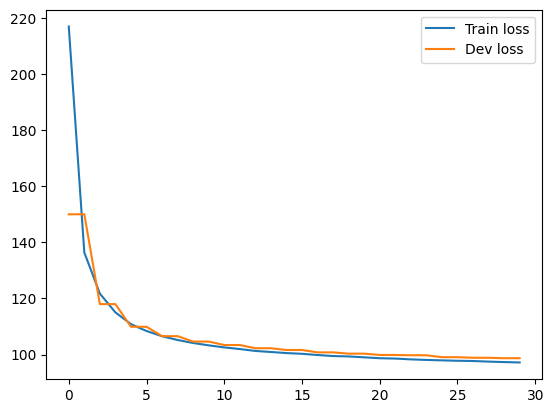

In [ ]:
plot_losses(vae_train_hist, vae_dev_hist)

# Inferring the VAE model

Albeit noisy, each of the inferred image is slightly different. More importantly, the resulting latent space is what is known as structured. Representations in latent space that are close, are also generating similar outputs.

In [21]:
def gen_samples(model, num_samples):
    model.train(False)
    with torch.no_grad():
        # generate random noise
        z= torch.randn(num_samples, model.embed_dim).to(device)
        samples= model.decode(z)

    return samples


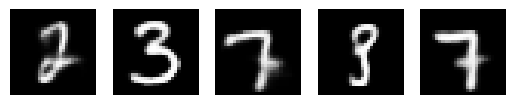

In [ ]:
samples= gen_samples(vae_model, num_samples=5)

fig, axarr= plt.subplots(1, 5)

# original image - positive pair
for i in range(samples.shape[0]):
    axarr[i].imshow(samples[i][0].detach().cpu().numpy(), cmap='gray')
    axarr[i].axis('off')

plt.show()

Variational Autoencoders (VAEs) have proven to be a groundbreaking advancement in the realm of machine learning and data generation.

While simple autoencoders can reconstruct images, they struggle with generating new data. Variational autoencoders (VAEs) offer a more flexible approach by learning parameters of a distribution of the latent space that can be sampled to generate new data. The re-parametrization trick is used to make the sampling operation differentiable. VAEs offer an improvement over simple autoencoders and have many applications, such as generative modelling, anomaly detection, and feature learning.

In [ ]:
# https://www.datacamp.com/tutorial/variational-autoencoders
# https://medium.com/@sofeikov/implementing-variational-autoencoders-from-scratch-533782d8eb95
# https://medium.com/correll-lab/a-deep-dive-into-autoencoders-ae-vae-and-vq-vae-with-code-ba712b9210eb
# https://avandekleut.github.io/vae/
# https://www.youtube.com/watch?v=pEsC0Vcjc7c
# https://medium.com/@mathparracho/variational-autoencoders-vaes-cvaes-%CE%B2-vaes-generative-intuition-practice-4b7b4011f55b

# Conditional Variational Autoencoders (CVAEs)

The **C** in CVAE stands for "conditional". This means that the encoder and decoder in addition to the input data (e.g. image for the encoder and latent vector for the decoder) are provided with an encoding for a condition. Therefore, the encoder does not need to represent the condition in the latent space since the decoder will also get this information as an extra input. Hence, the encoder can regress out the condition and learn e.g. the handwriting style as a latent representation.

In practice, conditions in CVAE models are commonly one-hot encoded. E.g. for the MNIST dataset with 10 different digits, we would use a size 10 vector. One-hot encodings work well, however, a trained model is limited to the conditions provided during training, due defined dimensions of the condition vector. If a CVAE model is trained on the MNSIT dataset for the digits 0-7 (using a size 8 one hot encoding), inference cannot be performed for digits 8 and 9.

**Using Learnable Conditional Embeddings:** These are unique vectors for each condition, but with values that will be updated in the training process. The model optimizer will update the embedding vectors together with all other model parameters to improve the loss during training. So we do not only have a latent space for images but also an embedding space for the conditions (digits). This means that we can add new digits to the model that were not included during training and the model might be able to infer the correct digit just with a new adjusted condition embedding.

In [ ]:
class CVAE(nn.Module):
    """
    Define the Conditional Variational Autoencoder model.
    """

    def __init__(self, n_classes, cls_embed_dim, embed_dim, image_size, input_chs, hidden_chs,
                 output_chs, kernels=3, paddings=1, max_pools=2, initp=True) -> None:
        super(CVAE, self).__init__()
        self.embed_dim= embed_dim
        # define the Learnable Conditional Embedding
        self.embed_cond= nn.Embedding(n_classes, cls_embed_dim, max_norm=True)
        # define mu and log(variance) layers
        self.mu   = nn.Linear(embed_dim, embed_dim)
        self.sigma= nn.Linear(embed_dim, embed_dim)

        # define the Conditional Variational Encoder-Decoder architecture
        self.encoder= Encoder(
            embed_dim, image_size, (input_chs+cls_embed_dim), hidden_chs, output_chs, kernels,
            paddings, max_pools, initp
        )
        dec_input_chs= output_chs
        dec_hidden_chs= hidden_chs[::-1]
        dec_output_chs= input_chs
        dec_strides= max_pools

        self.decoder= Decoder(
            (embed_dim+cls_embed_dim), self.encoder.flat_size, dec_input_chs,
            dec_hidden_chs, dec_output_chs, kernels, paddings, dec_strides, initp
        )


    def encode(self, x, y_emb):
        ones= torch.ones(x.shape, dtype=x.dtype, device=x.device)
        y= ones * y_emb.view(-1, y_emb.size(1), 1, 1)
        x= torch.cat((x, y), dim=1) # (batch_size, img_chs+cls_embed_dim, img_height, img_width)
        encoded= self.encoder(x)    # (batch_size, embed_dim)
        # outputs an encoded latent space
        return encoded


    def decode(self, z, y_emb):
        z= torch.cat((z, y_emb), dim=1) # (batch_size, embed_dim+cls_embed_dim)
        decoded= self.decoder(z)
        # outputs a decoded image from a latent space
        return decoded


    def reparameterize(self, mu, sigma):
        # compute the log(variance)
        sigma= torch.exp(0.5 * sigma)
        # generate a standard normal distribution
        n_dist= torch.distributions.Normal(0, 1)
        if mu.is_cuda:
            n_dist.loc  = n_dist.loc.cuda()  # hack to get sampling on the GPU
            n_dist.scale= n_dist.scale.cuda()

        return mu + sigma * n_dist.sample(mu.shape) # return the reparameterized sample


    def forward(self, x, y):
        # the labels are provided as variable y (non-one-hot vectors)
        y= self.embed_cond(y)             # (batch_size, cls_embed_dim)
        encoded= self.encode(x, y)        # (batch_size, embed_dim)
        # compute the mean and log(variance) vectors
        mu= self.mu(encoded)
        sigma= self.sigma(encoded)
        # sample a latent vector
        z= self.reparameterize(mu, sigma) # (batch_size, embed_dim)
        decoded= self.decode(z, y)        # (batch_size, img_chs, img_height, img_width)

        return encoded, decoded, mu, sigma


The model consists of an encoder and decoder (I adapted the model from the previous VAE). We first define the encoder, which takes as input the images and the conditional embedding and outputs a latent vector. The decoder is much simpler since it just uses a latent vector and the conditional embedding to infer images.

In [ ]:
# --- CVAE defs ---
n_classes= 10
cls_embed_dim= 8
embed_dim= 64
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128

cvae_model= CVAE(n_classes, cls_embed_dim,
                 embed_dim, image_size, input_chs, hidden_chs, output_chs).to(device)

# Encode a sample image and decode its latent vector
y_en, y_dec, _, _= cvae_model(Xtr[:1], torch.argmax(Ytr[:1], dim=1))
y_en.shape, y_dec.shape

(torch.Size([1, 64]), torch.Size([1, 1, 28, 28]))

**NOTE:** I defined **cls_embed_dim** (the dimensionality of the Conditional Embedding **embed_cond**) with a value of 8, which encodes 10 different labels using 8-dimensional vectors. That is a reasonable value for encoding a few labels, such as in this case (only 10). However, to encode more labels (e.g., the 1000 ones in ImageNet), the dimensionality of the Conditional Embedding must be increased accordingly.

In [ ]:
count_parameters(cvae_model)

cvae_model

Number of parameters: 501393


CVAE(
  (embed_cond): Embedding(10, 8, max_norm=True)
  (mu): Linear(in_features=64, out_features=64, bias=True)
  (sigma): Linear(in_features=64, out_features=64, bias=True)
  (encoder): Encoder(
    (conv_in): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ1): ReLU(inplace=True)
    (conv_hn): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ2): ReLU(inplace=True)
    (conv_out): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ3): ReLU(inplace=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (out_layer): Linear(in_features=1152, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (in_layer): Linear(in_features=72, out_fea

# Training the CVAE

TODO: Training using data augmentation.

In [ ]:
# transforming labels back from one-hot vectors of length 10 to numbers as required by our CVAE
Ytr= torch.argmax(Ytr, dim=1)
Ydev= torch.argmax(Ydev, dim=1)

# training and dev data were not touched
print(f'Shape of training: Xtr - {Xtr.shape}, Ytr - {Ytr.shape}')
print(f'Shape of dev data: Xdev - {Xdev.shape}, Ydev - {Ydev.shape}')

Shape of training: Xtr - torch.Size([48000, 1, 28, 28]), Ytr - torch.Size([48000])
Shape of dev data: Xdev - torch.Size([12000, 1, 28, 28]), Ydev - torch.Size([12000])


In [ ]:
def cvae_training(model, learning_rate=1e-3, epochs=500, eval_interval=5, batches:bool=True,
                  batch_size=64, shuffle:bool=True):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= math.floor(Xtr.shape[0]/ batch_size)
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # loss function
    loss_fn= KLDivergenceLoss()

    # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
    scheduler= ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.1, min_lr=1e-6)

    # tracking statistics
    train_hist= []
    dev_hist= []
    schedule_hist= []

    # training data indexes
    ix= torch.arange(0, Xtr.shape[0])

    # --- training loop ---
    for epoch in tqdm(range(epochs)):

        batch_loss= []
        batch_schedule= []

        # iterating over all batches
        if shuffle:
            ix= torch.randperm(Xtr.shape[0])[:Xtr.shape[0]]

        for i in range(epoch_size):
            # --- minibatch construction ---
            Xmb= Xtr[ix[(i * batch_size) : ((i+1) * batch_size)]]
            Ymb= Ytr[ix[(i * batch_size) : ((i+1) * batch_size)]]

            # --- forward pass and get loss ---
            model.train(True)
            _, y_dec, mu, sigma= model(Xmb, Ymb)
            loss_tr= loss_fn(y_dec, Xmb, mu, sigma)
            # KLDivergenceLoss returns a sum by default
            batch_loss.append(loss_tr.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss_tr.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss) / Xmb.shape[0])

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                _, y_dec, mu, sigma= model(Xdev, Ydev)
                loss_dev= loss_fn(y_dec, Xdev, mu, sigma)

        dev_hist.append(loss_dev.item() / Xdev.shape[0])
        schedule_hist.append(scheduler.get_last_lr())
        scheduler.step(train_hist[-1]) # step learning rate scheduler


    return train_hist, dev_hist, schedule_hist


In [ ]:
# --- CVAE defs ---
n_classes= 10
cls_embed_dim= 8
embed_dim= 64
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128

cvae_model= CVAE(n_classes, cls_embed_dim, embed_dim, image_size, input_chs, hidden_chs,
                 output_chs).to(device)

cvae_tr_hist, cvae_dev_hist, cvae_sched_hist= cvae_training(cvae_model, learning_rate=1e-3, epochs=30,
                                                            eval_interval=2, batch_size=256)

100%|██████████| 30/30 [21:07<00:00, 42.26s/it]


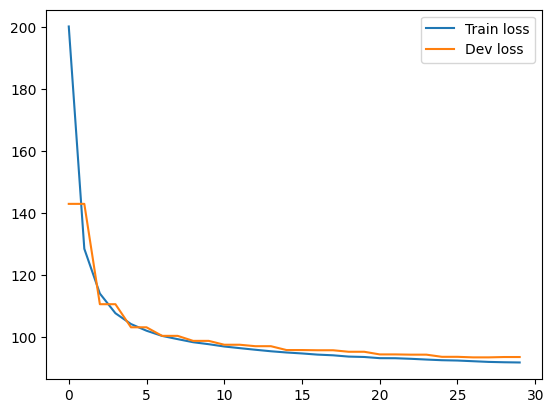

In [ ]:
plot_losses(cvae_tr_hist, cvae_dev_hist)

# Inferring the CVAE model

We can visually check how well the model is able to generate digits from the latent space. To do so, we create a grid in the latent space and letting the decoder generate images of the digits we are interested in. Since we only used a 2-dimensional latent space, we can use a 2D grid.

In [ ]:
def plot_reconstructed_cvae(model, target=2, grid=8, r0=(-3,3), r1=(-3,3),
                            device='cuda'):
    model.train(False)
    # define plot array
    fig, ax= plt.subplots(grid, grid)

    # loop over a grid in the latent space
    for i, a in enumerate(torch.linspace(*r1, grid)):
        for j, b in enumerate(torch.linspace(*r0, grid)):
            with torch.no_grad():
                z= torch.linspace(a, b, steps=model.embed_dim, device=device).view(1, model.embed_dim)
                y_emb= model.embed_cond(torch.tensor([target]).to(device))
                # forwardig the data through the decoder
                x_hat= model.decode(z, y_emb)

                x_hat= x_hat.reshape(x_hat.size(-2), x_hat.size(-1)).detach().cpu().numpy()
                ax[i, j].imshow(x_hat, cmap='gray')
                ax[i, j].axis('off')

    plt.show()


Especially in the center of the latent space, the digits are very clear. Overall, the decoder is able to generate readable images of handwritten digits for all the provided numbers during training.

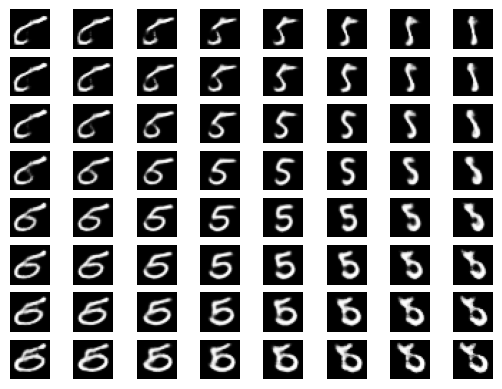

In [ ]:
plot_reconstructed_cvae(cvae_model, target=5, device=device)

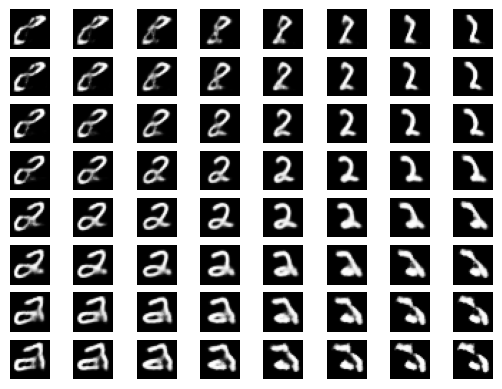

In [ ]:
plot_reconstructed_cvae(cvae_model, target=2, device=device)

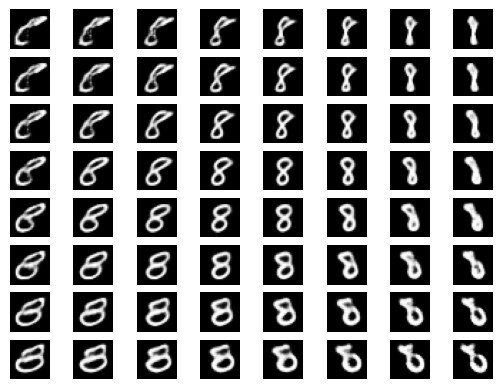

In [ ]:
plot_reconstructed_cvae(cvae_model, target=8, device=device)

In [ ]:
""" CVAEs with learnable conditional embeddings """
# https://towardsdatascience.com/conditional-variational-autoencoders-with-learnable-conditional-embeddings-e22ee5359a2a

In [ ]:
# https://towardsdatascience.com/understanding-conditional-variational-autoencoders-cd62b4f57bf8
# https://github.com/debtanu177/CVAE_MNIST/blob/master/train_cvae.py
# https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-cnn-cvae.ipynb

# Vector Quantized-Variational Autoencoders (VQ-VAEs)

VQ-VAEs are a type of generative model that combines the strengths of Autoencoders and discrete latent variable models. They are designed to handle discrete latent spaces efficiently, making them particularly useful for applications like image generation, audio synthesis, and text generation.

Traditional Variational Autoencoders (VAEs) use continuous latent variables, which are modeled using distributions like Gaussian. The drawback of the VAE is that it sacrificies reconstruction performance by learning average images — represented by their mean rather than fit the input data perfectly. This is why results appear blurred.
Furthermore, certain types of data (e.g., text, symbolic representations) benefit from discrete latent spaces. Discrete representations are also easier to model since each category has a single value whereas if we had a continous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.

In VQ-VAEs the latent vector $z_e$ is mapped to a discrete codebook $\mathcal{E} = \{e_1, e_2, \dots, e_K\}$, where $e_i$ are learned embeddings. The quantizer replaces $z_e$ with the closest embedding vector $e_k$ from the codebook:

$$
z_q = \text{Quantize}(z_e) = e_k \quad \text{where } k = \arg \min_j \| z_e - e_j \|^2
$$

Here, $z_q$ is the discretized version of the latent representation.

In the VectorQuantizer module, we define a latent embedding space (the codebook) of dimension **[K, D]** where **K** are the number of embeddings and **D** is the dimensionality of each latent embeddng vector, i.e. $e_i \in \mathbb{R}^{D}$. The intuition is that since the output representation of the encoder and the input to the decoder share the same **D** channel dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

In [ ]:
class VectorQuantizer(nn.Module):
    """
    Define the Vector Quantizer layer.
    - In the Commitment Loss, the encoder embeddings should be as close as possible to the actual
    codebook entries.
    - In the Codebook Loss, the codebook entries should be as close as possible to the encoder
    embeddings.
    """

    def __init__(self, codebook_size, embed_dim, commitment_cost) -> None:
        super(VectorQuantizer, self).__init__()
        self.codebook_size= codebook_size
        self.commitment_cost= commitment_cost
        # define the Learnable Codebook Embedding
        self.codebook= nn.Embedding(codebook_size, embed_dim)
        self.codebook.weight.data.uniform_(
            -1.0/math.sqrt(codebook_size), 1.0/math.sqrt(codebook_size)
        )


    def forward(self, z_e):
        # receive inputs from BCHW -> BD to quantize
        B, D= z_e.shape
        # compute pairwise distances
        distances= torch.cdist(z_e, self.codebook.weight)
        # encoding embedding vectors
        encoding_idx= torch.argmin(distances, dim=1)
        # retrieve quantized values from codebook
        quantized= self.codebook(encoding_idx).view(B, D)

        # here we use a computational trick that is known as "straight-through estimator"
        # commitment objective loss
        e_latent_loss= F.mse_loss(quantized.detach(), z_e)
        # codebook (vector quantization) objective loss
        q_latent_loss= F.mse_loss(quantized, z_e.detach())
        # quantization loss
        q_loss= q_latent_loss + self.commitment_cost * e_latent_loss

        quantized= z_e + (quantized - z_e).detach()
        quantized= quantized.contiguous()

        return quantized, q_loss


This module takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize. The output tensor will have the same shape as the input.

The total loss is actually composed of three components:

- **reconstruction loss**: which optimizes the decoder and encoder
- **codebook loss**: due to the fact that gradients bypass the embedding, we use a dictionary learning algorithm  which uses an $l_2$  error to move the embedding vectors $e_i$ towards the encoder output
- **commitment loss**:  since the volume of the embedding space is dimensionless, it can grow arbirtarily if the embeddings $e_i$ do not train as fast as  the encoder parameters, and thus we add a commitment loss to make sure that the encoder commits to an embedding

In [ ]:
class VQVAE(nn.Module):
    """
    Define the Vector Quantized-Variational Autoencoder model.
    """

    def __init__(self, codebook_size, commitment_cost, embed_dim, image_size, input_chs,
                 hidden_chs, output_chs, kernels=3, paddings=1, max_pools=2, initp=True) -> None:
        super(VQVAE, self).__init__()
        # define the VQ-VAE architecture
        self.encoder= Encoder(
            embed_dim, image_size, input_chs, hidden_chs, output_chs, kernels,
            paddings, max_pools, initp
        )
        # the vector quantizer
        self.quantizer= VectorQuantizer(codebook_size, embed_dim, commitment_cost)

        dec_input_chs= output_chs
        dec_hidden_chs= hidden_chs[::-1]
        dec_output_chs= input_chs
        dec_strides= max_pools

        self.decoder= Decoder(
            embed_dim, self.encoder.flat_size, dec_input_chs, dec_hidden_chs, dec_output_chs,
            kernels, paddings, dec_strides, initp
        )


    def encode(self, x):
        encoded= self.encoder(x)
        # outputs an encoded latent space
        return encoded


    def decode(self, z):
        zq, _= self.quantizer(z)
        decoded= self.decoder(zq)
        # outputs a decoded image from a latent space
        return decoded


    def forward(self, x):
        z= self.encoder(x)
        zq, q_loss= self.quantizer(z)
        decoded= self.decoder(zq)

        return decoded, q_loss


After the encoding, the VQ-VAE will select the code that has the closest Euclidian distance to the encoding, therefore forcing the embedding into a mold. When considering text, this would be akin to reduce to a subset of the alphabet, allowing the optimizer to choose which characters these are.

In addition, if we want to use the VQ-VAE for datacompression, we don't even have to provide the entire latent space, but simply the indices into the codebook. This makes this approach very compelling to generative models such as transformer decoders, which have to simply generate a sequence of codebook entries to generate consistent, high resolution images.

In [ ]:
# --- VQ-VAE defs ---
codebook_size= 32
commitment_cost= 0.2
embed_dim= 64
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128

vqvae_model= VQVAE(codebook_size, commitment_cost, embed_dim, image_size, input_chs, hidden_chs,
                   output_chs, initp=False).to(device)

# Encode a sample image and decode its latent vector
y_dec, vq_loss= vqvae_model(Xtr[:1])
y_dec.shape, vq_loss

(torch.Size([1, 1, 28, 28]),
 tensor(0.0103, device='cuda:0', grad_fn=<AddBackward0>))

In [ ]:
count_parameters(vqvae_model)

vqvae_model

Number of parameters: 483521


VQVAE(
  (encoder): Encoder(
    (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ1): ReLU(inplace=True)
    (conv_hn): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ2): ReLU(inplace=True)
    (conv_out): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ3): ReLU(inplace=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (out_layer): Linear(in_features=1152, out_features=64, bias=True)
  )
  (quantizer): VectorQuantizer(
    (codebook): Embedding(32, 64)
  )
  (decoder): Decoder(
    (in_layer): Linear(in_features=64, out_features=1152, bias=True)
    (make2d): Unflatten(dim=1, unflattened_size=torch.Size([128, 3, 3]))
  

# Training the VQ-VAE

In [ ]:
def vqvae_training(model, learning_rate=1e-3, epochs=500, eval_interval=5, batches:bool=True,
                   batch_size=64, shuffle:bool=True):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= math.floor(Xtr.shape[0]/ batch_size)
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.AdamW(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay, amsgrad=False
    )

    # loss function
    loss_fn= nn.MSELoss()

    # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
    scheduler= ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.05, min_lr=1e-4)


    # tracking statistics
    train_hist= []
    dev_hist= []
    schedule_hist= []

    # training data indexes
    ix= torch.arange(0, Xtr.shape[0])

    # --- training loop ---
    for epoch in tqdm(range(epochs)):

        batch_loss= []
        batch_schedule= []

        # iterating over all batches
        if shuffle:
            ix= torch.randperm(Xtr.shape[0])[:Xtr.shape[0]]

        for i in range(epoch_size):
            # --- minibatch construction ---
            Xmb= Xtr[ix[(i * batch_size) : ((i+1) * batch_size)]]

            # --- forward pass and get loss ---
            model.train(True)
            optimizer.zero_grad()
            y_dec, vq_loss= model(Xmb)
            reconstruction_loss= loss_fn(y_dec, Xmb)
            loss_tr= reconstruction_loss + vq_loss

            # --- backward pass to calculate the gradients ---
            loss_tr.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()
            batch_loss.append(reconstruction_loss.item())


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                y_dec, vq_loss_dev= model(Xdev)
                reconstruction_loss= loss_fn(y_dec, Xdev)
                loss_dev= reconstruction_loss + vq_loss_dev

        dev_hist.append(loss_dev.item())
        schedule_hist.append(scheduler.get_last_lr())
        scheduler.step(train_hist[-1]) # step learning rate scheduler


    return train_hist, dev_hist, schedule_hist


In [ ]:
# --- VQ-VAE defs ---
codebook_size= 32
commitment_cost= 0.2
embed_dim= 64
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128

vqvae_model= VQVAE(codebook_size, commitment_cost, embed_dim, image_size, input_chs, hidden_chs,
                   output_chs, initp=False).to(device)

vqvae_tr_hist, vqvae_dev_hist, _= vqvae_training(vqvae_model, learning_rate=1e-3,
                                                 epochs=30, eval_interval=2, batch_size=256)

100%|██████████| 30/30 [20:20<00:00, 40.68s/it]


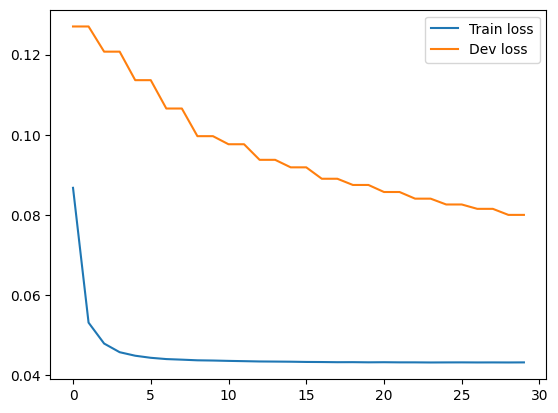

In [ ]:
plot_losses(vqvae_tr_hist, vqvae_dev_hist)

# Inferring the VQ-VAE model

In [ ]:
from torchvision.utils import make_grid

def plot_samples(img):
    npimg= img.numpy()
    fig= plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

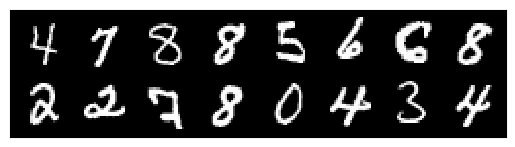

In [ ]:
valid_originals= Xdev[:16]

plot_samples(make_grid(valid_originals.cpu()))

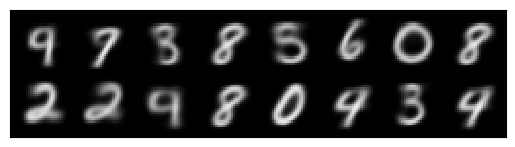

In [ ]:
vqvae_model.train(False)
with torch.no_grad():
    valid_reconstructions, _= vqvae_model(valid_originals)

plot_samples(make_grid(valid_reconstructions.cpu()))

In [ ]:
# https://www.youtube.com/watch?v=VZFVUrYcig0
# https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb
# https://www.youtube.com/watch?v=1ZHzAOutcnw
# https://github.com/explainingai-code/VQVAE-Pytorch
# https://github.com/ritheshkumar95/pytorch-vqvae/tree/master

# VQ-VAE using Residual-based CNNs and CIFAR-10

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# load the CIFAR-10 dataset
training_data= datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std= [1.0, 1.0, 1.0]),
    ])
)
validation_data= datasets.CIFAR10(
    root='./data', train=False,download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std= [1.0, 1.0, 1.0]),
    ])
)
# necessary steps to use the above transform operations (raw image preprocessing) and match the
# training function "data loader" scheme
training_loader= DataLoader(training_data, batch_size=training_data.data.shape[0])
validation_loader= DataLoader(validation_data, batch_size=validation_data.data.shape[0])
# a better practice would be to feed a DataLoader and use it directly on the training function

Xtr, Ytr= next(iter(training_loader))
Xdev, Ydev= next(iter(validation_loader))

Xtr, Ytr = Xtr.to(device), Ytr.to(device)
Xdev,Ydev= Xdev.to(device),Ydev.to(device)

Xtr.shape, Xdev.shape

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


(torch.Size([50000, 3, 32, 32]), torch.Size([10000, 3, 32, 32]))

# 2D Vector Quantizer

In this case, a **BCHW** image tensor of shape **[16, 64, 32, 32]** is converted to an **BHWC** tensor of shape **[16, 32, 32, 64]** (by permuting its channel dimension) and then reshaped into **[16384, 64]** -- and all **16384** vectors of size **64**  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and seen as different examples to quantize, **16384** in this case.

In [ ]:
class VectorQuantizer2d(nn.Module):
    """
    Define the 2D Vector Quantizer layer.
    """

    def __init__(self, codebook_size, embed_dim, commitment_cost) -> None:
        super(VectorQuantizer2d, self).__init__()
        self.codebook_size= codebook_size
        self.commitment_cost= commitment_cost
        # define and initialize the Learnable Codebook Embedding
        self.codebook= nn.Embedding(codebook_size, embed_dim)
        self.codebook.weight.data.uniform_(
            -1.0/math.sqrt(codebook_size), 1.0/math.sqrt(codebook_size)
        )


    def forward(self, z_e):
        # receive inputs from BCHW -> BHWC to quantize
        z_e= z_e.permute(0, 2, 3, 1).contiguous()
        B, H, W, C= z_e.shape
        z_e_flat= z_e.view(-1, C)
        # compute pairwise distances -- this approach is more efficient for large-scale
        # codebooks (torch.matmul is highly optimized on GPUs) than previous torch.cdist
        distances= torch.clamp(
            torch.sum(z_e_flat ** 2, dim=1, keepdim=True) + \
            torch.sum(self.codebook.weight**2, dim=1) - 2 * \
            torch.matmul(z_e_flat, self.codebook.weight.t()), min=0
        )
        # encoding embedding vectors
        encoding_idx= torch.argmin(distances, dim=1)
        # retrieve quantized values from codebook
        quantized= self.codebook(encoding_idx).view(B, H, W, C)

        # commitment objective loss
        e_latent_loss= F.mse_loss(quantized.detach(), z_e)
        # codebook (vector quantization) objective loss
        q_latent_loss= F.mse_loss(quantized, z_e.detach())
        # quantization loss
        q_loss= q_latent_loss + self.commitment_cost * e_latent_loss

        quantized= z_e + (quantized - z_e).detach()
        # convert quantized from BHWC -> BCHW
        quantized= quantized.permute(0, 3, 1, 2).contiguous()

        return quantized, q_loss


**Slightly modified version:** using exponential moving averages (EMA). This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [ ]:
class VectorQuantizer2dEMA(nn.Module):
    """
    Define the 2D Vector Quantizer layer with exponential moving averages (EMA) to update the
    embedding vectors instead of an auxillary loss.
    """

    def __init__(self, codebook_size, embed_dim, commitment_cost, decay, epsilon=1e-5) -> None:
        super(VectorQuantizer2dEMA, self).__init__()
        self.codebook_size= codebook_size
        self.commitment_cost= commitment_cost
        self.decay= decay
        self.eps= epsilon
        # define and initialize the Learnable Codebook Embedding
        self.codebook= nn.Embedding(codebook_size, embed_dim)
        self.codebook.weight.data.normal_()
        # define and initialize the EMA elements
        self.register_buffer("ema_cluster_size", torch.zeros(codebook_size))
        self.ema_w= nn.Parameter(torch.Tensor(codebook_size, embed_dim))
        self.ema_w.data.normal_()


    def forward(self, z_e):
        # receive inputs from BCHW -> BHWC to quantize
        z_e= z_e.permute(0, 2, 3, 1).contiguous()
        B, H, W, C= z_e.shape
        z_e_flat= z_e.view(-1, C)
        # compute pairwise distances -- this approach is more efficient for large-scale
        # codebooks (torch.matmul is highly optimized on GPUs) than previous torch.cdist
        distances= torch.clamp(
            torch.sum(z_e_flat ** 2, dim=1, keepdim=True) + \
            torch.sum(self.codebook.weight**2, dim=1) - 2 * \
            torch.matmul(z_e_flat, self.codebook.weight.t()), min=0
        )
        # encoding embedding vectors
        encoding_idx= torch.argmin(distances, dim=1)
        encodings= torch.zeros(
            encoding_idx.unsqueeze(1).shape[0], self.codebook_size, device=z_e.device
        )
        encodings.scatter_(1, encoding_idx.unsqueeze(1), 1)
        # retrieve quantized values from codebook
        quantized= self.codebook(encoding_idx).view(B, H, W, C)

        # Use EMA to update the embedding vectors
        if self.training:
            # update the cluster size -- in-place update
            self.ema_cluster_size.data.mul_(self.decay).add_(
                (1 - self.decay) * torch.sum(encodings, 0)
            )
            # Laplace smoothing of the cluster size
            n= torch.sum(self.ema_cluster_size.data)
            self.ema_cluster_size= (
                (self.ema_cluster_size + self.eps) / (n + self.codebook_size * self.eps) * n
            )
            # update codebook vectors using EMA
            dw= torch.matmul(encodings.T, z_e_flat)
            self.ema_w= nn.Parameter(self.ema_w * self.decay + (1 - self.decay) * dw)
            self.codebook.weight= nn.Parameter(self.ema_w / self.ema_cluster_size.unsqueeze(1))

        # commitment objective loss
        e_latent_loss= F.mse_loss(quantized.detach(), z_e)
        # quantization loss
        q_loss= self.commitment_cost * e_latent_loss

        quantized= z_e + (quantized - z_e).detach()
        # convert quantized from BHWC -> BCHW
        quantized= quantized.permute(0, 3, 1, 2).contiguous()

        return quantized, q_loss


# Residual Block

The decision to use **bias=False** for convolutional layers is based on the interaction between the convolutional layers and Batch Normalization.

In [ ]:
class ResidualBlock(nn.Module):
    """
    Define a Pre-activation Residual Block.
    """

    def __init__(self, hidden_chs, in_out_chs, dropout=0.1) -> None:
        super(ResidualBlock, self).__init__()
        # convolutional sequential layers
        self.block= nn.Sequential(
            nn.BatchNorm2d(in_out_chs),
            nn.GELU(),
            nn.Conv2d(in_out_chs, hidden_chs, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(hidden_chs),
            nn.GELU(),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(hidden_chs, in_out_chs, kernel_size=1, stride=1, padding=0, bias=False),
        )


    def forward(self, x):
        # in_channels=out_channels=in_out_chs, so we don't need a shortcut connection here
        x= x + self.block(x)

        return x


class ResidualStack(nn.Module):
    """
    Define a stack of residual blocks.
    """

    def __init__(self, n_blocks, hidden_chs, in_out_chs, dropout=0.1) -> None:
        super(ResidualStack, self).__init__()
        self.blocks= nn.ModuleList([
            ResidualBlock(hidden_chs, in_out_chs) for _ in range(n_blocks)
        ])
        self.activ= nn.GELU()


    def forward(self, x):
        for block in self.blocks:
            x= block(x)

        return self.activ(x)


Pooling can lose spatial information. If your task requires detailed reconstructions (as in many autoencoders), consider replacing **MaxPool2d** with strided convolutions to downsample the feature maps. This is especially beneficial for dense prediction tasks (e.g., segmentation).

**Dropout2d** prevents overfitting by zeroing out entire feature maps while keeping the spatial structure intact. On the other hand, **Dropout** with convolutional layers is less common but still valid. It would randomly set individual pixels to zero, which might disrupt the spatial consistency of the features.

In [ ]:
class EncoderV2(nn.Module):
    """
    Define a more robust Encoder module using residual CNN blocks.
    Returns a tensor of shape (batch_size, channels, height, width).
    """

    def __init__(self, input_chs, hidden_chs, output_chs, n_residual_blocks=1,
                 kernels=4, paddings=1, strides=2, dropout=0.1, initp=True) -> None:
        super(EncoderV2, self).__init__()
        self.embed_dim= output_chs
        # convolutional layers
        self.conv_1= nn.Sequential(
            nn.Conv2d(input_chs, hidden_chs[0], kernels, strides, paddings, bias=False),
            nn.BatchNorm2d(hidden_chs[0]),
            nn.GELU(),
            nn.Dropout2d(p=dropout),
        )
        self.conv_2= nn.Sequential(
            nn.Conv2d(hidden_chs[0], hidden_chs[1], kernels, strides, paddings, bias=False),
            nn.BatchNorm2d(hidden_chs[1]),
            nn.GELU(),
        )
        self.conv_3= nn.Conv2d(
            hidden_chs[1], output_chs, kernels-1, strides-1, paddings, bias=False
        )
        self.residuals= ResidualStack(
            n_residual_blocks, hidden_chs[1], output_chs
        )

        if initp:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                    if m.bias is not None: nn.init.zeros_(m.bias)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1.0)
                    nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        z= self.conv_1(x)
        z= self.conv_2(z)
        z= self.conv_3(z)
        z= self.residuals(z)

        return z  # outputs an encoded latent space


In [ ]:
class DecoderV2(nn.Module):
    """
    Define a more robust Decoder module using residual CNN blocks.
    """

    def __init__(self, input_chs, hidden_chs, output_chs, n_residual_blocks=1,
                 kernels=4, paddings=1, strides=2, dropout=0.1, initp=True) -> None:
        super(DecoderV2, self).__init__()
        # convolutional input layers
        self.residuals= ResidualStack(
            n_residual_blocks, hidden_chs[0], input_chs
        )
        # convT layers -- in_channels, out_channels, kernel_size, stride, padding
        self.convT_1= nn.Sequential(
            nn.ConvTranspose2d(input_chs, hidden_chs[0], kernels-1, strides-1, paddings, bias=False),
            nn.BatchNorm2d(hidden_chs[0]),
            nn.GELU(),
        )
        self.convT_2= nn.Sequential(
            nn.ConvTranspose2d(hidden_chs[0], hidden_chs[1], kernels, strides, paddings, bias=False),
            nn.BatchNorm2d(hidden_chs[1]),
            nn.GELU(),
            nn.Dropout2d(p=dropout),
        )
        self.convT_3= nn.ConvTranspose2d(
            hidden_chs[1], output_chs, kernels, strides, paddings, bias=False
        )

        if initp:
            for m in self.modules():
                if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                    nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                    if m.bias is not None: nn.init.zeros_(m.bias)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1.0)
                    nn.init.constant_(m.bias, 0.0)


    def forward(self, z):
        x= self.residuals(z)
        x= self.convT_1(x)
        x= self.convT_2(x)
        x= self.convT_3(x)

        return x  # outputs a decoded image from a latent space


In [ ]:
class VQVAE2(nn.Module):
    """
    Define the Vector Quantized-Variational Autoencoder using residual CNN blocks.
    """

    def __init__(self, codebook_size, embed_dim, commitment_cost,
                 input_chs, hidden_chs, output_chs, n_residual_blocks=1, kernels=4,
                 paddings=1, strides=2, dropout=0.1, decay=0.0, epsilon=1e-5, initp=True) -> None:
        super(VQVAE2, self).__init__()
        # define the 2D-only VQ-VAE architecture
        self.encoder= EncoderV2(
            input_chs, hidden_chs, output_chs, n_residual_blocks,
            kernels, paddings, strides, dropout, initp
        )
        # the 2D vector quantizer
        self.pre_vq_conv= nn.Conv2d(
            in_channels=output_chs, out_channels=embed_dim, kernel_size=1, stride=1
        )
        if decay> 0.0:
            self.quantizer= VectorQuantizer2dEMA(
                codebook_size, embed_dim, commitment_cost, decay, epsilon
            )
        else:
            self.quantizer= VectorQuantizer2d(
                codebook_size, embed_dim, commitment_cost
            )
        self.pos_vq_conv= nn.Conv2d(
            in_channels=embed_dim, out_channels=output_chs, kernel_size=1, stride=1
        )
        dec_input_chs = output_chs
        dec_hidden_chs= hidden_chs[::-1]
        dec_output_chs= input_chs

        self.decoder= DecoderV2(
            dec_input_chs, dec_hidden_chs, dec_output_chs, n_residual_blocks,
            kernels, paddings, strides, dropout, initp
        )


    def encode(self, x):
        encoded= self.encoder(x)
        encoded= self.pre_vq_conv(encoded)
        # outputs an encoded latent space
        return encoded


    def decode(self, z):
        zq, _= self.quantizer(z)
        zq= self.pos_vq_conv(zq)
        decoded= self.decoder(zq)
        # outputs a decoded image from a latent space
        return decoded


    def forward(self, x):
        z= self.encoder(x)
        z= self.pre_vq_conv(z)
        zq, q_loss= self.quantizer(z)
        zq= self.pos_vq_conv(zq)
        decoded= self.decoder(zq)

        return decoded, q_loss


In [ ]:
# --- 2D VQ-VAE defs ---
codebook_size= 512
embed_dim= 64
commitment_cost= 0.25
input_chs= 3
hidden_chs= [32,64]
output_chs= 128
n_residual_blocks= 2

vqvae2_model= VQVAE2(codebook_size, embed_dim, commitment_cost, input_chs, hidden_chs, output_chs,
                     n_residual_blocks).to(device)

y_dec, loss= vqvae2_model(Xtr[:1])
y_dec.shape, loss

(torch.Size([1, 3, 32, 32]),
 tensor(0.5068, device='cuda:0', grad_fn=<AddBackward0>))

In [ ]:
count_parameters(vqvae2_model)
vqvae2_model

Number of parameters: 595008


VQVAE2(
  (encoder): EncoderV2(
    (conv_1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Dropout2d(p=0.1, inplace=False)
    )
    (conv_2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (residuals): ResidualStack(
      (blocks): ModuleList(
        (0-1): 2 x ResidualBlock(
          (block): Sequential(
            (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): GELU(approximate='none')
            (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padd

# Training and Inferring the non-EMA VQ-VAE

In [ ]:
# --- 2D VQ-VAE defs ---
codebook_size= 512
embed_dim= 64
commitment_cost= 0.25
input_chs= 3
hidden_chs= [32,64]
output_chs= 128
n_residual_blocks= 2
initp= True

vqvae2_model= VQVAE2(codebook_size, embed_dim, commitment_cost, input_chs, hidden_chs, output_chs,
                     n_residual_blocks, initp=initp).to(device)

vqvae_tr_hist, vqvae_dev_hist, _= vqvae_training(vqvae2_model, learning_rate=1e-3,
                                                 epochs=100, eval_interval=2, batch_size=256)

100%|██████████| 100/100 [02:56<00:00,  1.77s/it]


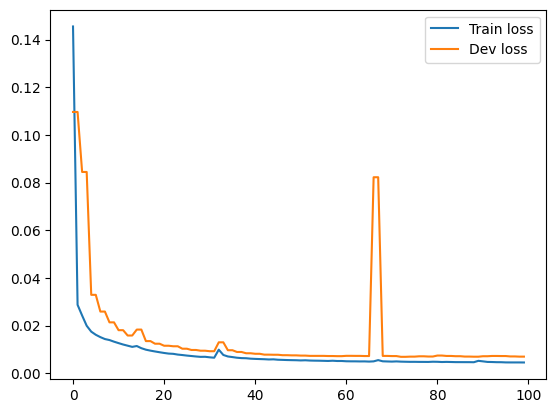

In [ ]:
"""
Here I used initp= True when building the VQVAE2 model.
"""
plot_losses(vqvae_tr_hist, vqvae_dev_hist)

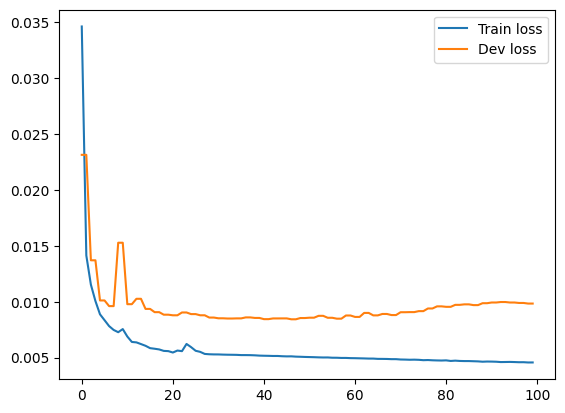

In [ ]:
"""
Here I used initp= False when building the VQVAE2 model.
"""
plot_losses(vqvae_tr_hist, vqvae_dev_hist)

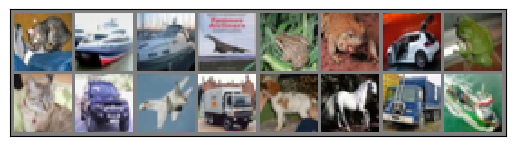

In [ ]:
valid_originals= Xdev[:16]

plot_samples(make_grid(valid_originals.cpu())+0.5)

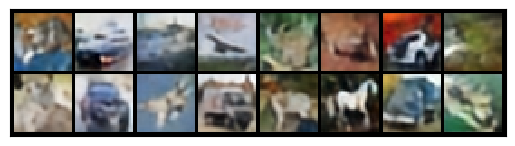

In [ ]:
vqvae2_model.eval()
with torch.no_grad():
    vq_output_eval= vqvae2_model.encode(valid_originals)
    valid_reconstructions= vqvae2_model.decode(vq_output_eval)
    valid_reconstructions= torch.clip(valid_reconstructions+0.5, min=0.0, max=1.0)

plot_samples(make_grid(valid_reconstructions.cpu()))

# Training and Inferring the EMA VQ-VAE

In [ ]:
# --- 2D VQ-VAE defs ---
codebook_size= 512
embed_dim= 64
commitment_cost= 0.25
input_chs= 3
hidden_chs= [32,64]
output_chs= 128
n_residual_blocks= 2
decay= 0.99
initp= True

vqvae2_model= VQVAE2(codebook_size, embed_dim, commitment_cost, input_chs, hidden_chs, output_chs,
                     n_residual_blocks, decay=decay, initp=initp).to(device)

count_parameters(vqvae2_model)

vqvae_tr_hist, vqvae_dev_hist, _= vqvae_training(vqvae2_model, learning_rate=1e-3,
                                                 epochs=100, eval_interval=2, batch_size=256)

Number of parameters: 627776


100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


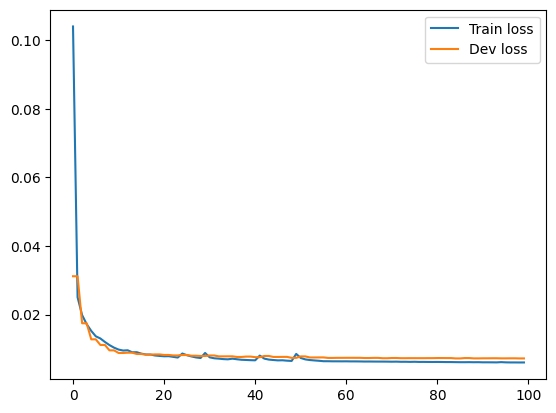

In [ ]:
plot_losses(vqvae_tr_hist, vqvae_dev_hist)

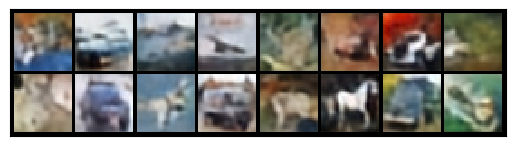

In [ ]:
vqvae2_model.eval()
with torch.no_grad():
    vq_output_eval= vqvae2_model.encode(valid_originals)
    valid_reconstructions= vqvae2_model.decode(vq_output_eval)
    valid_reconstructions= torch.clip(valid_reconstructions+0.5, min=0.0, max=1.0)

plot_samples(make_grid(valid_reconstructions.cpu()))

In [ ]:
# https://medium.com/correll-lab/a-deep-dive-into-autoencoders-ae-vae-and-vq-vae-with-code-ba712b9210eb